This is the jupyter notebook from the PyVBMC website. It did make things very confusing for a while.

# PyVBMC Example 1: Basic usage

In this introductory example, we will show a simple usage of Variational Bayesian Monte Carlo (VBMC) to perform Bayesian inference on a synthetic target.

This notebook is Part 1 of a series of notebooks in which we present various example usages for VBMC with the PyVBMC package. The code used in this example is available as a script [here](https://github.com/acerbilab/pyvbmc/blob/main/examples/scripts/pyvbmc_example_1_full_code.py).

In [24]:
import numpy as np
import scipy.stats as scs
from pyvbmc import VBMC
import math

## 0. What is the goal of (Py)VBMC?

VBMC is an algorithm to efficiently perform Bayesian inference, and PyVBMC is its Python implementation. We recall that the goal of Bayesian inference is to obtain the *posterior distribution* $p(\mathbf{x}|\mathcal{D})$  for a vector of model parameters $\textbf{x}$ and data set $\mathcal{D}$. The calculation involves [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$
p(\mathbf{x}|\mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{x}) p(\mathbf{x})}{p(\mathcal{D})},
$$

where $p(\mathcal{D}|\mathbf{x})$ is the *likelihood*, $p(\mathbf{x})$ is the *prior*, and $p(\mathcal{D})$ is the normalization constant, also known as the *model evidence* or *marginal likelihood*.

VBMC takes as input the unnormalized log posterior, or log (joint) density, $\log p(\mathcal{D}|\mathbf{x}) p(\mathbf{x})$ (also known as the *target*), and outputs: 
- a *variational posterior* $q(\textbf{x}|\mathcal{D})$ which is an (often very accurate) approximation of the true posterior;
- an approximate lower bound to the log marginal likelihood, called ELBO (**e**vidence **l**ower **bo**und), and an estimate of its uncertainty;

all using as few target evaluations as possible.
In the following, we see how to set up and run PyVBMC on a toy example.

## 1. Model definition: log-likelihood, log-prior, and log-joint

Normally, the log-likelihood function $\log p(\mathcal{D}|\mathbf{x})$ depends on the model under consideration, where $\mathcal{D}$ is the data and $\mathbf{x}$ is a vector of $D$ model parameters.
For this example, we set as toy log-likelihood for our model a broad [Rosenbrock's banana function](https://en.wikipedia.org/wiki/Rosenbrock_function) in $D = 2$. 

In [26]:
D = 2  # We consider a 2-D problem
# D = 2

def log_likelihood(theta):
    """D-dimensional Rosenbrock's banana function."""
    theta = np.atleast_2d(theta)

    x, y = theta[:, :-1], theta[:, 1:]
    
    return -np.sum(100/(math.exp(-100*(1/50)*x + math.log(9))+1), axis=1)


# In general, `log_likelihood` would depend on the data and *your* particular model

We define now a prior $p(\mathbf{x})$ over the parameters. For simplicity, we set an independent Gaussian prior on each variable, but you could use any prior of your choice. Note that PyVBMC uses the logarithm of the prior, $\log p(\mathbf{x})$. 

Since in this example the priors for each variable are independent, we compute the log-prior separately for each variable and then sum them:

$$
\log p(\mathbf{x}) = \log \prod_{d = 1}^{D} p(x_d) = \sum_{d = 1}^{D} \log p(x_d).
$$


In [27]:
prior_mu = np.zeros((1, D))
prior_std = 3 * np.ones((1, D))


def log_prior(x):
    """Independent normal prior."""
    return np.sum(scs.norm.logpdf(x, prior_mu, prior_std))

By default PyVBMC assumes that the provided `target` function is the log-joint, or unnormalized log posterior, defined as:

$$
\log p(\mathcal{D}, \mathbf{x}) = \log p(\mathcal{D}| \mathbf{x}) p(\mathbf{x}) = \log p(\mathcal{D}| \mathbf{x}) + \log p(\mathbf{x}).
$$


In [28]:
def log_joint(x):
    """log-density of the joint distribution."""
    return log_likelihood(x) + log_prior(x)

## 2. Parameter setup: bounds and starting point

We assume an unconstrained domain for the model parameters, that is $\mathbf{x} \in \mathbb{R}^D$, specifying `-inf` and `inf` for the lower and upper bounds, respectively.

In [29]:
LB = np.full((1, D), -np.inf)  # Lower bounds
UB = np.full((1, D), np.inf)  # Upper bounds

PyVBMC also requires the user to specify so-called *plausible bounds* which should denote a region of high posterior probability mass. The plausible range is used to initialize some hyperparameters of the inference algorithm and guide the initial exploration of the posterior landscape, but it does not otherwise affect the model (although a good choice of plausible range can considerably improve convergence of the algorithm).

Not knowing better, we use mean +/- 1 SD of the prior (that is, the top ~68% prior credible interval) to set the plausible bounds.

In [30]:
PLB = prior_mu - prior_std  # Plausible lower bounds
PUB = prior_mu + prior_std  # Plausible upper bounds

# Alternatively, you could set the plausible bounds using the quantiles:
# PLB = scs.norm.ppf(0.1587, prior_mu, prior_std)
# PUB = scs.norm.ppf(0.8413, prior_mu, prior_std)

As a starting point $\mathbf{x}_0$ for the algorithm, we use the mean of the prior:

In [31]:
x0 = np.copy(prior_mu)

# Alternatively, we could use a random sample from inside the plausible box:
# x0 = PLB + np.random.uniform(size=(1,D))*(PUB - PLB)

## 3. Initialize and run inference

We now initialize the `vbmc` object which takes care of the inference. For now, we use default options.

In [32]:
vbmc = VBMC(log_joint, x0, LB, UB, PLB, PUB)

To perform inference, we run `vbmc.optimize()`.

The algorithm returns the variational posterior `vp` and a `results` dictionary containing additional information about the optimization, which we will analyze in more detail in a subsequent notebook.

In [33]:
vp, results = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


NameError: ("name 'log' is not defined", 'FunctionLogger:FuncError Error in executing the logged functionwith input: [0. 0.]')

Two especially relevant statistics are the lower bound on the log model evidence (`results["elbo"]`), and its uncertainty (`results["elbo_sd"]`):

In [13]:
lml_true = -2.272  # ground truth, which we know for this toy scenario

print("The true log model evidence is:", lml_true)
print("The obtained ELBO is:", format(results["elbo"], ".3f"))
print("The obtained ELBO_SD is:", format(results["elbo_sd"], ".3f"))

The true log model evidence is: -2.272
The obtained ELBO is: -2.254
The obtained ELBO_SD is: 0.000


### Remarks:
- The ELBO is a *lower bound* on the true log model evidence $\log p(\mathcal{D})$. The better the approximation of the posterior, the closer the ELBO is to the true log model evidence.
- PyVBMC does not aim for high numerical precision of the ELBO (e.g., beyond the 1st or 2nd decimal place). In most realistic model-fitting problems, a higher resolution is not necessary.
- The reported standard deviation of the ELBO, `elbo_sd`, is a measure of the uncertainty on the ELBO as estimated via Bayesian quadrature (the approximation technique used by PyVBMC). `elbo_sd` is **not** a measure of the difference between the ELBO and the true log model evidence, which is generally unknown. 

## 4. Examine and visualize results

We now examine the obtained variational posterior. We can easily draw hundreds of thousands of random samples from the variational posterior to compute summary statistics of interests.

For reporting uncertainty on model parameter estimates, you could use posterior mean +/- SD, or the median and interquartile range of the samples (the latter is better for a posterior that deviates substantially from Gaussian).

In [14]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(3e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [0.00600932 1.17497135]
The approximate posterior covariance matrix is:
 [[1.24093689 0.00809032]
 [0.00809032 2.01376705]]


Finally, we visualize the obtained variational approximation `vp` via the `vp.plot()` function, which is based on the beautiful `corner.py` module (see [here](https://corner.readthedocs.io/en/latest/)).

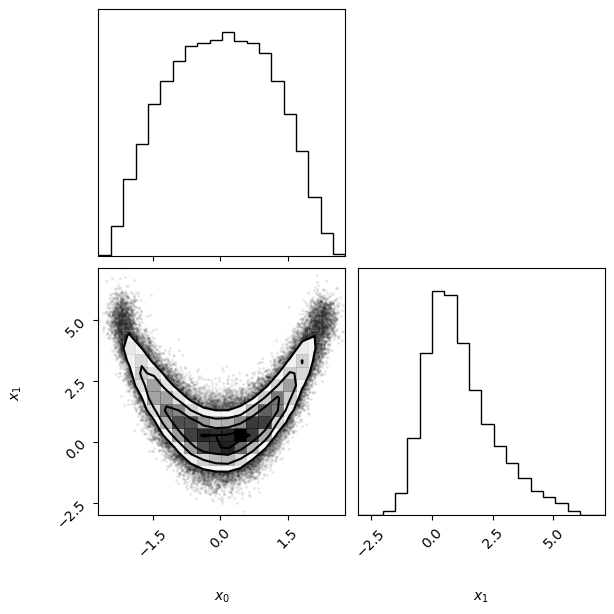

In [15]:
vp.plot();

The figure represents the multidimensional variational posterior `vp` via one- and two-dimensional marginal plots for each variable and pairs of variables.

Here, the bottom-left panel represents the two-dimensional joint distribution of $x_1$ and $x_2$, whereas the two panels on the diagonal represent the one-dimensional marginal distributions of $x_1$ and $x_2$, respectively. Note that PyVBMC has managed to approximate very well the highly non-Gaussian shape of the target density.

## 5. Conclusions

In this notebook, we have seen how to set up and run Bayesian inference with PyVBMC with a fairly minimal example.

An important step which is not considered in this example is a thorough validation of the results and diagnostics, which will be discussed in a later notebook.

The next notebook will look more in detail at the output trace and plots of PyVBMC, which is a good starting point to check how inference is proceeding.

## Acknowledgments

Work on the PyVBMC package was funded by the [Finnish Center for Artificial Intelligence FCAI](https://fcai.fi/).